# Apresentação:

O objetivo desse código é explorar um pouco sobre sistemas de classificação. Não terá abordagem a alguma classe de modelo em específico aqui, mas apenas o funcionamento geral e elementos de metrificação da classificação.

## Classificação:
Classificação são problemas de predição, na classe de problemas de aprendizado supervisionado, cujo os quais o espaço de saídas é um conjunt $C$ de **classes** não ordenadas e mutualmente excludentes tal que $\mathcal{y} = {1,2,...,C}$. Basicamente podemos resumir a classificação como um **problema de predição no domínio discreto**. Apesar de uma mudança sutil, isso gera mudanças fundamentais na estruturação dos modelos.

## Material Base:

O material utilizado aqui será o livro **Hands On Machine Learning with Scikit-Learn, Keras & TensorFlow** de *Aurélien Géron*, para a estruturação prática do código, com a suplementação do **Probabilistic Machine Learning: An Introduction** de *Kevin Murphy* e **The Elements of Statistical Learning** de *Trevor Hastie*, *Robert Tibshirani* e *Jerome Friedman* para aprofundamento teórico.


## Documentações:

Também contamos com a documentação das bibliotecas utilizadas para apoio no entendimento do código.

* https://scikit-learn.org/stable/
* https://matplotlib.org/
* https://seaborn.pydata.org/

In [1]:
# Bibliotecas para visualização:
import seaborn as sns
import  matplotlib as mpl
from matplotlib import pyplot as plt

# Bibliotecas suporte:
import numpy as np
from time import time
from tqdm import tqdm

# Conhecendo os dados:

Para treinamento do modelo, será utilizado o clássico [**MNIST**](https://yann.lecun.com/exdb/mnist/) ao qual é um grande banco de dados de **dígitos manuscritos**, comumente usado para treinar vários sistemas de processamento de imagens.

## MNIST:

O conjunto de imagens no banco de dados [MNIST](https://pt.wikipedia.org/wiki/Banco_de_dados_MNIST) foi criado em 1994 como uma combinação de dois bancos de dados do **NIST**: Banco de dados especial 1 e banco de dados especial 3, que consistem em dígitos escritos por estudantes do ensino médio e funcionários do Departamento do Censo dos Estados Unidos, respectivamente.

O conjunto de dados original era um conjunto de imagens binárias de 128x128, processadas em imagens em escala de cinza de 28x28. Originalmente, havia 60 mil amostras no conjunto de treinamento e no conjunto de teste, mas 50 mil do conjunto de teste foram descartadas. [Consulte Cold Case: The Lost MNIST Digits](https://arxiv.org/pdf/1905.10498) para um histórico detalhado e uma reconstrução do conjunto de teste descartado.rtado.

In [2]:
# Importando Conjunto de Dados:
from sklearn.datasets import fetch_openml

In [3]:
# Aquisitando dados:
mnist = fetch_openml("mnist_784",version=1);mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
# Separando covariáveis do target:
X, y = mnist["data"].values, mnist["target"].values # Passando para numpy

print(type(X), X.shape)
print(type(y), y.shape)

<class 'numpy.ndarray'> (70000, 784)
<class 'pandas.core.arrays.categorical.Categorical'> (70000,)


Ou seja, temos a Matriz, ou tensor de segunda ordem, $X \in \mathbb{R}^2$ tal que $X_{(70000 \times 784)}$ e o vetor, ou tensor de primeira ordem, $y \in \mathbb{R}$ tal que $y_{(70000 \times 1)}$. Note também que o tipo de dados dados já veem como objeto pandas. Entender isso é importante, pois os dados precisam estar numa estrutura adequada para que não haja problemas.

In [5]:
# Biblioteca para gerar Valor aleatório:
from random import randint as rand

Numero: 1


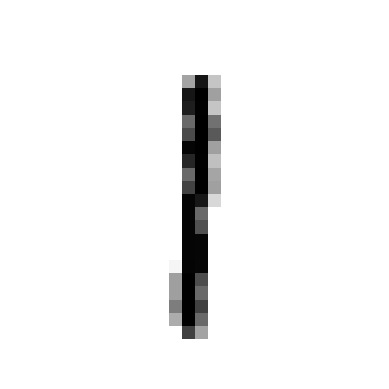

In [6]:
indice = rand(0, len(X))
some_digit = X[indice]
some_digit_image = some_digit.reshape(28, 28)
print(f'Numero: {y[indice]}')
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

O `fetch_openml` talvez não seja a melhor opção para a importação dos dados. Inclusive porque, até onde me parece, ela é uma opção antiga. Eu fiz por que é a forma que o livro faz, mas existem outras formas de se aquisitar esse conjunto de dados.

## Digits dataset:

Caso haja problema em utilizar essa função, uma outra abordagem é recorrer ao dataset `digits` que é conjunto de dados similar ao MNIST, acho que poderiamos resumi-lo como um MNIST simplificado. Talvez alguns tutoriais na internet até o usem chamando-o de MNIST.

In [7]:
# Importando datasets:
from sklearn.datasets import load_digits

In [8]:
# Carregando Dataset:
digits = load_digits() #load the dataset in digits
digits.data.shape

(1797, 64)

In [9]:
# Elementos do conjunto de dados:
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

É um dataset menor, mas também serve, caso haja problema com o `fetch_openml`.

# Preparando os dados:

Essa é uma etapa muito importante da construção do modelo, afinal, os dados precisam estar estruturados de forma adequada para a modelagem escolhida.

## Avaliando a tipologia dos dados:

Para que a modelagem funcione adequadamente, os dados precisam estar estruturados de forma adequada. Não precisamos checar aqui dados faltantes, NaN, porém, a tipologia é interessante checar. Não podemos fazer contas com strings, por exemplo, então os dados precisam estar no tipo correto para a modelagem.

In [10]:
# Chegando tipologia dos labels:
print(type(y), type(y[indice]), y[indice])

<class 'pandas.core.arrays.categorical.Categorical'> <class 'str'> 1


In [11]:
# Tranformando as string em números:
y = y.astype(np.uint8)

In [12]:
# Checando novamente tipologia dos labels:
print(type(y), type(y[indice]), y[indice])

<class 'numpy.ndarray'> <class 'numpy.uint8'> 1


## Dados de Treino e de Teste:

O primeiro passo importante é separar os dados entre dados de treino e dados de teste. Isso se dá, porque precisamos validar a qualidade do modelo em predizer conteúdos além dos quais ele foi treinado, mas que ainda sejam dados que estão dentro do propósito do modelo predizer. Basicamente a ideia aqui é estabelecer uma estratégia de metricação, controlando possíveis *Overfittings*

In [13]:
# Separando os dados:
Xtrain, Xtest, ytrain, ytest = X[:60000], X[60000:],y[:60000],y[60000:]

# Modelagem:

Passada a etapa de preparação dos dados, podemos finalmente começar a modelagem dos dados em si.

## Treinando um Binary Classifier:

Os modelos de Classificação Binária são modelos simples, capazes de lidar apenas com duas classes, $C = \{0,1\}$ por exemplo. A ideia é utilizar esse classificador apenas como pretexto para falar das métricas de validação de um modelo de classificação. A ideia do livro é classificar o numéro 5, então será o que faremos aqui.

In [14]:
# Gerando vetores de treinamento:
ytrain5 = (ytrain == 5) # Verdadeiro para 5's, falso caso contrário.
ytest5 = (ytest == 5)

## Stochastic Gradient Descent (SGD) classifier:

Um bom lugar para começar é com um **Gradiente Descendent Estocastico (SGD)** como classificador, usando a classe `SGDClassifier` do Scikit-Learn. Este classificador tem a vantagem de ser capaz de lidar com conjuntos de dados muito grandes de forma eficiente. Isto ocorre em parte porque o SGD lida com instâncias de treinamento de forma independente, uma de cada vez (o que também torna o SGD adequado para *aprendizagem online*), como veremos mais tarde. Vamos criar um `SGDClassifier` e treine-o em todo o conjunto de treinamento.

In [15]:
# Modelo Utilizado:
from sklearn.linear_model import SGDClassifier

In [16]:
# Intanciando Modelo:
sgd_clf = SGDClassifier(random_state=42)

# Trainando Modelo:
sgd_clf.fit(Xtrain, ytrain5)

SGDClassifier(random_state=42)

O `SGDClassifier` depende da aleatoriedade durante o treinamento (portanto o nome “estocástico”). Se você quiser resultados reproduzíveis, você deve definir o parâmetro random_state.

In [17]:
i = 0
if sgd_clf.predict([X[i]]):
    print(f'Verdade, o numeor é {y[i]}')

Verdade, o numeor é 5


# Mensurando Performance:

A mudança no dominio das variáveis resposta gera toda uma mudança de abordagem na construção dos modelos. Dada essa mudança substancial na modelagem, surge dai novas formas de mensurar a performance dos modelos.

## Implementando a Validação Cruzada:

O método de validação cruzada é muito importante para a construção de um modelo de qualidade. A ideia é simples, "*Quem garante que você escolheu a amostra certa na construção do modelo?*". A resposta desse questionamento é, "*então vamos testar com todas as amostras possíveis*". Dá pra simplificar isso como um processo de reamostragem. A ideia é simples, divide um conjunto em $k$ subconjuntos consecutivas, $k$ é usado como teste enquanto $k-1$ como treinamento, então, para cada conjunto de teste, é criado uma validação.

In [18]:
# Importações para validação Cruzada:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone # Para clonar o modelo.

O `StratifiedKFold` é uma variação do `KFold`. O `KFold` tradicional fornece índices de treinamento/teste para dividir dados em conjuntos de treinamento/teste. Divida o conjunto de dados em k dobras consecutivas (sem embaralhar por padrão). O `StratifiedKFold` retorna dobras **estratificadas**. As dobras são feitas preservando a porcentagem de amostras de cada classe, ou seja, ele pondera a quantidade de dobras pela quantidades de classes, uma boa opção para lidar com dados **desbalanceados**.

In [19]:
# Instanciando o KFold Estratíficado:
skfolds = StratifiedKFold(n_splits=3, random_state=42,shuffle=True) # Shuffle ativado:

In [20]:
acuracias = []
inicio = time()
# Gerando Métricas:
for train_index, test_index in tqdm(skfolds.split(Xtrain, ytrain5)):
    # Gerando partições:
    clone_clf = clone(sgd_clf) # Para cada folder
    XtrainFolds = Xtrain[train_index]
    ytrainFolds = ytrain5[train_index]
    XtestFold = Xtrain[test_index]
    ytestFold = ytrain5[test_index]

    # Gerando Mensuração:
    clone_clf.fit(XtrainFolds,ytrainFolds)
    ypred = clone_clf.predict(XtestFold)
    n_correct = sum(ypred == ytestFold) # Soma 1 a cada acerto.
    acuracia = n_correct/len(ypred) # Calculando a acurácia do modelo

    acuracias.append(acuracia)
final = time()

print(f'Tempo Gasto: {round(final-inicio,2)} segundos')

3it [00:25,  8.53s/it]

Tempo Gasto: 25.59 segundos


In [21]:
for i,acuracia in enumerate(acuracias):
    print(i,acuracia)

0 0.9669
1 0.91625
2 0.96785


In [22]:
# Média dos validações:
print(f'{round(sum(acuracias)/len(acuracias),2)}% de acurácia total')

0.95% de acurácia total


In [23]:
# Variância:
desvioPadrao = np.array(acuracias).std();desvioPadrao
print(f'Desvio Padrão = {round(desvioPadrao,3)}')

Desvio Padrão = 0.024


Podemos também implementar a própria estrutura do `sklearn` para realizar a validação cruzada. Para isso, vamos usar a função `cross_val_score()` para avaliar seu modelo `SGDClassifier` usando validação cruzada K-fold, com três dobras. Lembre-se de que a validação cruzada K-fold significa dividir o conjunto de treinamento em K-folds (neste caso, três) e, em seguida, fazer fazer previsões e avaliá-las em cada dobra usando um modelo treinado no dobras restantes.

In [24]:
# Importando a validação Cruzada:
from sklearn.model_selection import cross_val_score

In [25]:
inicio = time()
# Realizando a Validação Cruzada:
acuraciasSklearn = cross_val_score(sgd_clf, Xtrain, ytrain5, cv=3, scoring="accuracy");acuraciasSklearn
final = time()
print(f'Tempo Gasto: {round(final-inicio,2)} segundos')

Tempo Gasto: 21.03 segundos


In [26]:
# Checando Valor a valor:
for i in range(0,3):
    print(f'{acuracias[i]} - {acuraciasSklearn[i]}, Iguais? {acuracias[i] == acuraciasSklearn[i]}')

0.9669 - 0.95035, Iguais? False
0.91625 - 0.96035, Iguais? False
0.96785 - 0.9604, Iguais? False


In [27]:
# Estaísticas das acurácias do SKlean:
meanSK = acuraciasSklearn.mean()
desvioPadraoSK = acuraciasSklearn.std()
print(f'Média: {round(meanSK,2)}')
print(f'Desvio Padrão: {round(desvioPadraoSK,4)}')

Média: 0.96
Desvio Padrão: 0.0047


## Matriz de Confusão:

A **matriz de confusão** é uma forma visual de avaliar a qualidade do modelo. A ideia é simples, queremos que os labels preditos pelo modelo coincidam com os labels reais. Utilizando a função `confusion_matrix()` do `sklearn` podemos gerar uma matriz que possibilita visualizar, classe a classe, quantas vezes elas se coincidem. Obviamente, para gerar a matriz de confusão, precisamos ter as predições, então vamos utilizar a função `cross_val_predict()` para gerar as predições para cada *fold* de modo a termos uma matriz de predições.

In [28]:
# Importando a função de predições:
from sklearn.model_selection import cross_val_predict

In [29]:
# Realizando Predições:
y_train_pred = cross_val_predict(sgd_clf, Xtrain, ytrain5, cv=3);y_train_pred

array([ True, False, False, ...,  True, False, False])

Assim como a função `cross_val_score()`, `cross_val_predict()` executa a validação cruzada com K-fold, mas em vez de retornar as pontuações da avaliação, retorna as previsões feitas em cada dobra de teste. Isso significa que você obtém uma previsão limpa para cada instância no conjunto de treinamento (“limpo”, significando que a previsão é feita por um modelo que nunca viu os dados durante o treinamento).

In [30]:
# Importando Matriz de Confusão:
from sklearn.metrics import confusion_matrix

In [31]:
matrizConfusion = confusion_matrix(ytrain5, y_train_pred);matrizConfusion

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Uma outra forma de visualizar isso, é utilizar a método `.heatmap()` do `seaborn` para deixar a visualização mais agradável.

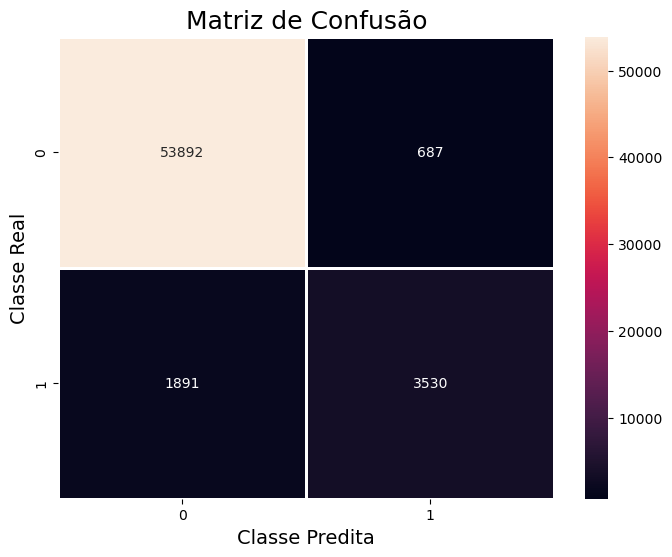

In [32]:
# Configurando o tamanho da figura
plt.figure(figsize=(8, 6))

# Criando o heatmap
sns.heatmap(matrizConfusion, annot=True, fmt='d', cbar=True, linewidths=1)

# Adicionando títulos e rótulos
plt.title('Matriz de Confusão', fontsize=18)
plt.xlabel('Classe Predita', fontsize=14)
plt.ylabel('Classe Real', fontsize=14)

# Exibindo o gráfico
plt.show()

Note que desse jeito, conseguimos visualizar bem os **valores verdadeiros**, os **falsos positivos** e **falsos negativos**

# Métricas Importantes:

Dado a **matriz de confusão**, existem algumas métricas importantes e muito comumente usadas no contexto de **classificação**. São elas,

* Acurácia;
* Precisão;
* Recall;
* F1-Score.

Para simplificar a nomenclatura, aqui utilizaremos,

* **VP** = **V**erdadeiro **P**ositivo;
* **FP** = **F**also **P**ositivo;
* **VN** = **V**erdadeiro **N**egativo;
* **FN** = **F**also **N**egativo.

A ideia aqui é calcular esses métodos com o sklearn, e com funções próprias, de modo que conseguiremos inclusive comparar os resultados.

# Acurácia:

Já falamos de acurácia, mas eu vou voltar nela aqui para defini-la melhor. A acurácia é uma das métricas mais básicas, não levando em consideração as nuances com relação a predição no caso de classificação. Matematicamente temos,

$$\text{Acurácia} = \frac{VP+VN}{VP+FP+VN+FN}$$

In [53]:
def acuracia(matConfusao):
    '''
    Função que calcula a acurácia do modelo
    dada sua matriz de confusão.

    # Entrada:
    numpy.obj: A nossa matriz de confusão.

    # Saída:
    float: Acurácia do modelo.
    '''

    # Separando Elementos:
    vp = matrizConfusion[1][1]
    vn = matConfusao[0][0]
    predicts = sum(sum(matrizConfusion)) # Total de predições

    # Calculo de acurácia:
    acuracia = (vp+vn)/predicts

    return acuracia

In [79]:
# Checando a acurácia do modelo:
acuracy = round(acuracia(matrizConfusion),4)*100 # Passando para porcentagem
print(f'A acurácia do modelo é de {acuracy}%')

A acurácia do modelo é de 95.7%


# Precisão:

Precisão, também chamada de **valor preditivo positivo**, é outra métrica de mensuração da qualidade do modelo que também é construida através da matriz de confusão, porém olhando apenas para os valores positivos da predição e podemos defini-la como,

$$\text{Precisão} = \frac{VP}{VP+FP}$$

É importante notar que a $\text{precisão}\neq \text{acuracia}$, inclusive há uma interpretação importante aqui, dado que **precisão é o inverso da variância** e **acurácia é o inverso do viés**, ou seja, duas métricas diferentes para falar de elementos muito importantes na construção do modelo. (Lembre-se do exemplo do tiro ao alvo. Precisão mede o agrupamento dos tiros, acurácia mede a tendencia ao centro do alvo).

In [57]:
def precisao(matConfusao):
    '''
    Função construida para calcular a precisão
    do modelo dado a matriz de confusão.
    '''

    # Extraindo elementos:
    vp = matrizConfusion[1][1]
    fp = matrizConfusion[0][1]


    # Calculando a precisão:
    precisao = vp/(vp+fp)

    return precisao

In [59]:
# Checando a precisão do modelo:
precision = round(precisao(matrizConfusion),4)*100 # Passando para porcentagem
print(f'A precisão do modelo é de {precision}%')

A precisão do modelo é de 83.71%


In [69]:
# Importando a método de precisão:
from sklearn.metrics import precision_score

In [73]:
# Precisão sklearn
precision_score(ytrain5, y_train_pred)

0.8370879772350012

# Recall (Revocação):

Recall (ou sensibilidade) é uma métrica usada para avaliar a capacidade do modelo de identificar corretamente as instâncias positivas, ou seja, ele mede a fração das instâncias positivas que foram corretamente identificadas pelo modelo, de modo que, a medida que $\text{FN} \rightarrow 0$, $\text{Recall} \rightarrow 1$. Podemos então defini-lo como,

$$\text{Recall} = \frac{VP}{VP+FN}$$

In [60]:
def recall(matConfusao):
    '''
    Função de 
    '''

    # Extriando Elementos:
    vp = matrizConfusion[1][1]
    fn = matrizConfusion[1][0]

    # Calcula o Recall:
    recall = vp/(vp+fn)

    return recall

In [78]:
# Checando o recall do modelo:
rec = round(recall(matrizConfusion),4)*100 # Passando para porcentagem
print(f'O recall do modelo é de {rec}%')

O recall do modelo é de 65.12%


In [74]:
# Importando a método de Recall:
from sklearn.metrics import recall_score

In [75]:
recall_score(ytrain5, y_train_pred)

0.6511713705958311

# F1-Score:

O **F1 Score** é a **média harmônica de precisão e recuperação**. Esta métrica dá peso igual à precisão e ao recall, portanto leva em consideração tanto o número de erros cometidos pelo modelo quanto o tipo de erros. O F1 Score favorece modelos com precisão e recall semelhantes e é uma métrica útil se estivermos buscando um modelo com desempenho razoavelmente bom em ambas as métricas.

$$\text{F1-Score}=\frac{2}{\frac{1}{\text{Precisão}}+\frac{1}{\text{Recall}}}=\frac{2\times\text{Recall}\times\text{Precisão}}{\text{Recall}+\text{Precisão}}$$

In [82]:
def f1Score(matConfusao):

    # Calculando F1-Score:
    f1score = 2*recall(matConfusao)*precisao(matConfusao)/(recall(matConfusao)+precisao(matConfusao))

    return f1score

In [84]:
# Checando o F1-Score do modelo:
f1score = round(f1Score(matrizConfusion),4)*100 # Passando para porcentagem
print(f'A precisão do modelo é de {f1score}%')

A precisão do modelo é de 73.25%


In [85]:
# Importando F1-Score do Sklean
from sklearn.metrics import f1_score

In [86]:
# F1-Score:
f1_score(ytrain5, y_train_pred)

0.7325171197343847

# *Tradeoff* entre Precisão vs Recall:

Para entender esse *Tradeoff*, vamos analisar como o `SGDClassifier` toma suas decisões de classificação. Para cada instância, ele calcula uma pontuação com base em uma função de decisão e, se essa pontuação for maior que um determinado limiar, ele atribui a instância à classe positiva; caso contrário, ele a atribui à classe negativa. A Figura 3-3 mostra alguns dígitos posicionados da menor pontuação, à esquerda, até a maior pontuação, à direita. Suponha que o limiar de decisão esteja posicionado na seta central (entre os dois dígitos 5): você encontrará 4 verdadeiros positivos (5s reais) à direita desse limiar e um falso positivo (na verdade, um 6). Portanto, com esse limiar, a precisão é de 80% (4 em 5). Mas, de 6 dígitos 5 reais, o classificador detecta apenas 4, então o recall é de 67% (4 em 6). Agora, se você aumentar o limiar (movê-lo para a seta à direita), o falso positivo (o dígito 6) se torna um verdadeiro negativo, aumentando assim a precisão (até 100% neste caso), mas um verdadeiro positivo se torna um falso negativo, diminuindo o recall para 50%. Por outro lado, baixar o limiar aumenta o recall e reduz a precisão.